In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms as transforms
from sklearn.model_selection import train_test_split


In [2]:
train_data = pd.read_csv("C:\\Datasets\\sign_minist\\sign_mnist_train.csv")
test_data = pd.read_csv("C:\\Datasets\\sign_minist\\sign_mnist_test.csv")

In [3]:
train_data.shape,test_data.shape

((27455, 785), (7172, 785))

In [4]:
train_data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [5]:
train_data.label.nunique()

24

In [6]:
X_train = train_data.drop(['label'],axis=1).values
X_test = test_data.drop(['label'],axis=1).values
y_train = train_data['label'].values
y_test = test_data['label'].values

In [7]:
X_train.shape,y_train.shape

((27455, 784), (27455,))

In [8]:
# We need to normalize our image/rescale our images
X_train = X_train/255
X_test = X_test/255

In [9]:
X_train.shape

(27455, 784)

In [10]:
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)

In [11]:
X_test.shape

(7172, 1, 28, 28)

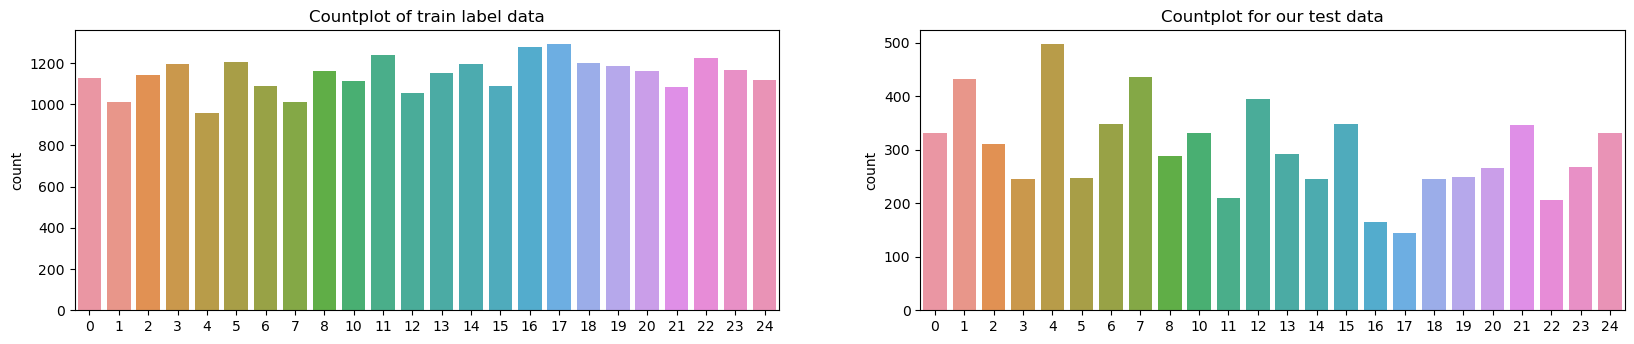

In [12]:
# Plotting a countplot for our Label data
import seaborn as sns
fig = plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.countplot(x= y_train)
plt.title('Countplot of train label data')
plt.subplot(2,2,2)
sns.countplot(x=y_test)
plt.title('Countplot for our test data')
plt.show()

<Figure size 1500x500 with 0 Axes>

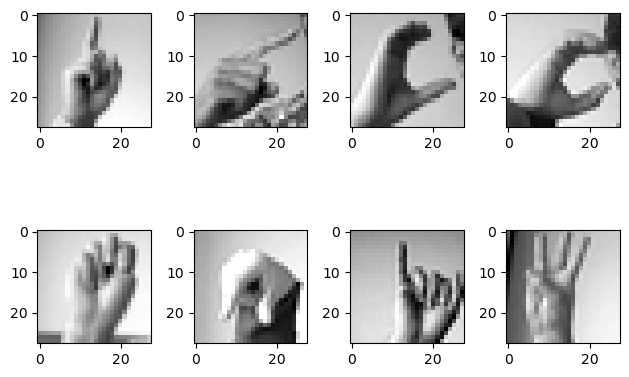

In [13]:
# Plot the First 8 Samples
fig = plt.figure(figsize=(15,5))
f,graph = plt.subplots(2,4)
f.set_size_indices = (14,5)
z = 0
for i in range(2):
    for k in range(4):
        graph[i][k].imshow(X_train[z].reshape(28,28),cmap='gray')
        graph[i][k].grid(False)
        z+=1
plt.tight_layout()
plt.show()

In [14]:
# Convert our data into Tensors
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [15]:
X_train.shape

torch.Size([27455, 1, 28, 28])

In [16]:
# Create a Dataset using Tensor Dataset
from torch.utils.data import DataLoader,TensorDataset
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

In [17]:
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [18]:
print(f"There are a total of :{len(train_loader)}|training batches")
print(f"There are a total of :{len(test_loader)}|testing batches")

There are a total of :858|training batches
There are a total of :225|testing batches


In [19]:
train_data.label.nunique() # This is to get the output of our model

24

# CONVOLUTIONAL NEURAL NETWORK (CNN) MODEL ::

In [35]:
# I am going to replicate the TinyVGG Model 
class SignLanguage(nn.Module):
    def __init__(self,input_dim=1,hidden_dim=10,output_dim=24,dropout=0.4):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(dropout)
        # I will create 4 layers : 2 Conv Blocks,2 linear block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=input_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=hidden_dim,out_channels= hidden_dim,kernel_size=3,padding=1,stride=1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(kernel_size=3))
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=hidden_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),
                                       nn.ReLU(),nn.Conv2d(in_channels=hidden_dim,out_channels=hidden_dim,kernel_size=3,padding=1,stride=1),nn.MaxPool2d(kernel_size=3))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(hidden_dim*3*3,output_dim))
    def forward(self,x:torch.Tensor):
        x = F.relu(x)
        x = self.convblock1(x)
        print(f"Output shape of :{x.shape}")
        x = self.convblock2(x)
        print(f"Output shape of :{x.shape}")
        # Using output to get the in_features of our Linear Layer
        # The output shape for our conv 2 layer is [1,10,3,3]
        # Running the model without tuning gives an Error :: Mat 1 and Mat 2 cannot be multiplied
        # The shape of mat 1 is 90*1 which is 10*3*3 ,which we replace in our model
        x = x.unsqueeze(0)
        x = self.fc1(x)
        return x

In [36]:
model = SignLanguage()

In [47]:
import random
random_image = random.choice(X_test)

In [48]:
prediction = model(random_image.unsqueeze(dim=1))

Output shape of :torch.Size([1, 10, 9, 9])
Output shape of :torch.Size([1, 10, 3, 3])


In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [50]:
random_prediction = model.forward(random_image)

Output shape of :torch.Size([10, 9, 9])
Output shape of :torch.Size([10, 3, 3])


In [51]:
random_prediction.shape

torch.Size([1, 24])

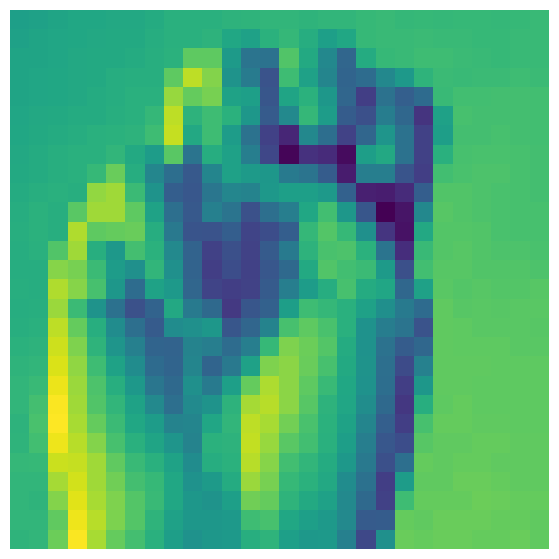

In [53]:
fig = plt.figure(figsize=(10,7))
plt.imshow(random_image.squeeze())
plt.axis(False)
plt.show()

In [ ]:
import tqdm